In [16]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from pdf2image import convert_from_path
from fpdf import FPDF
import noise
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageEnhance

from skimage.util import random_noise

def noise_Gaussian(img):
    if isinstance(img, Image.Image):
        img = np.array(img)
    img = random_noise(img, mode='gaussian', mean=0, var=0.06, clip=True)
    img = (255*img).astype(np.uint8)
    return img
def noise_SP(img):
    if isinstance(img, Image.Image):
        img = np.array(img)
    img = random_noise(img, mode='s&p', salt_vs_pepper=0.5, clip=True)
    img = (255*img).astype(np.uint8)
    return img
def blur_Gaussian(img):
    if isinstance(img, Image.Image):
        img = np.array(img)
    kernel = np.ones((3,3),np.float32)/9
    img = cv2.filter2D(img,-1,kernel)
    return img
def random_crop(img):
    if isinstance(img, Image.Image):
        img = np.array(img)
    h,w,d = img.shape
    sx,sy = random.randint(0,h//4), random.randint(0,w//4)
    ex,ey = sx + random.randint(h//2,(h//4)*3), sy + random.randint(w//2,(w//4)*3)
    img = img[sx:ex,sy:ey]
    return img
def flip(img):
    if isinstance(img, Image.Image):
        img = np.array(img)
    h,w,d = img.shape
    for i in range(h):
        for j in range(w//2):
            img[i][j], img[i][w-j-1] = img[i][w-j-1].copy(), img[i][j].copy()
    return img
def random_contrast(img):
    if isinstance(img, Image.Image):
        img = np.array(img)
    img_pil = Image.fromarray(img)
    factor = random.uniform(0.5, 1.5)
    enhancer = ImageEnhance.Contrast(img_pil)
    img_enhanced = enhancer.enhance(factor)
    
    return np.array(img_enhanced)

def convert_pdfs_to_images(pdf_dir):
    parent_dir = os.path.dirname(pdf_dir)  
    image_dir = os.path.join(parent_dir, 'image_testdata')
    os.makedirs(image_dir, exist_ok=True)

    # Get a list of all files in the directory
    files = os.listdir(pdf_dir)
    pdf_files = [file for file in files if file.endswith('.pdf')]
    for pdf_file in pdf_files:
        images = convert_from_path(os.path.join(pdf_dir, pdf_file))
        
        # Save each page as an image in the new directory
        for i, image in enumerate(images):
            image.save(os.path.join(image_dir, f'{pdf_file[:-4]}_{i}.jpg'), 'JPEG')

def convert_images_to_pdfs(image_dir):
    files = os.listdir(image_dir)
    jpg_files = [file for file in files if file.endswith('.jpg')]
    
    for jpg_file in jpg_files:
        pdf = FPDF()
        pdf.add_page()

        image_path = os.path.join(image_dir, jpg_file)
        with Image.open(image_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_path_rgb = os.path.join(image_dir, 'temp_rgb.jpg')
            img.save(img_path_rgb)

            width, height = img.size
            aspect_ratio = width / height
            max_width = 190
            max_height = 280
            if aspect_ratio > 1:
                img_width = max_width
                img_height = img_width / aspect_ratio
            else:
                img_height = max_height
                img_width = img_height * aspect_ratio

            pdf.image(img_path_rgb, x=10, y=8, w=img_width, h=img_height)
        
        output_pdf_path = os.path.join(image_dir, f"{jpg_file[:-4]}.pdf")
        pdf.output(output_pdf_path)
        print(f"PDF created successfully: {output_pdf_path}")
        os.remove(img_path_rgb)  



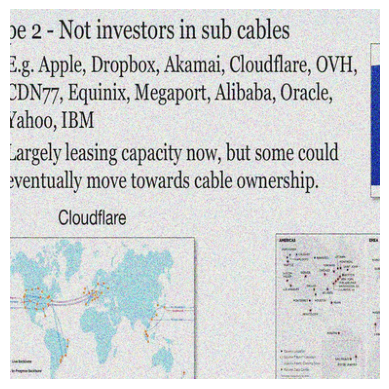

In [25]:

image_path = '/Users/nika/cloudtopology/GoogleScrap/image_testdata/augmented_image_testdata/Cloudflaremap_0_augmented_1.jpg'  
image = Image.open(image_path)  
noisy_image = image.resize((380, 380), Image.Resampling.LANCZOS)
noisy_image.save('/Users/nika/downloads/resized1.jpg')
plt.imshow(noisy_image)
plt.axis('off') 
plt.show()

In [27]:
def noise_augment(img,crop=True,canflip=True,blur=True):
    if (random.random() < 0.5):
        img = noise_Gaussian(img)
    else:
        img = noise_SP(img)
    if crop:
        img = random_crop(img)
    if (random.random()<0.5 and canflip):
        img = flip(img)
    if (random.random()<0.5 and blur):
        img = blur_Gaussian(img)
    return img
def apply_random_augmentations(img):

    augmentations = [blur_Gaussian, random_crop, flip, random_contrast]
    
    noise_functions = [noise_Gaussian, noise_SP]
    guaranteed_noise = random.choice(noise_functions)
    
    # guaranteed noise function 
    img = guaranteed_noise(img)
    
    # Randomly determine the number of additional augmentations to apply (0 to 3)
    num_additional_augmentations = random.randint(1, 3)
    
    # Randomly select that number of additional augmentation functions
    selected_augmentations = random.sample(augmentations, num_additional_augmentations)
    for func in selected_augmentations:
        img = func(img)
    
    return img

def resize_image(img, size=(380, 380)):

    img = img.resize(size, Image.ANTIALIAS)
        # Save the resized image
    img.save(output_path)

def augment_images_in_directory(input_dir):

    output_dir = os.path.join(input_dir, 'augmented_image_testdata')
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.endswith('.jpg'): 
            img_path = os.path.join(input_dir, filename)
            img = Image.open(img_path)
            img = np.array(img)
            
            #three  augmented images
            for i in range(1, 4):  #loop three times for three different augmentations
                augmented_img = apply_random_augmentations(img)
                
                augmented_img_pil = Image.fromarray(augmented_img.astype('uint8'), 'RGB')
                
                new_filename = f"{filename.rsplit('.', 1)[0]}_augmented_{i}.jpg"
                
                augmented_img_pil.save(os.path.join(output_dir, new_filename))

def resize_images_in_directory(input_dir, output_dir, size=(380, 380)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            try:
                with Image.open(input_path) as img:
                    resized_img = img.resize(size, Image.Resampling.LANCZOS)
                    resized_img.save(output_path)
                print(f"Resized and saved {filename}")
            except Exception as e:
                print(f"Failed to resize {filename}: {e}")
if __name__=="__main__":
    #resize_image("cloudtopology/GoogleScrap/image_testdata/augmented_image_testdata/2021-CTG-Infrastructure-Map-_0_augmented_1.jpg","Users/nika/Downloads/resized_image.jpg")
    input_directory = '/Users/nika/cloudtopology/GoogleScrap/image_testdata/augmented_image_testdata'  # Replace with your source directory path
    output_directory = '/Users/nika/cloudtopology/GoogleScrap/resized_image_testdata/resized_augmented_image_testdata'  # Replace with your desired output directory path
    resize_images_in_directory(input_directory, output_directory)
   # path = input("Image directory path:")
    #convert_pdfs_to_images("/Users/nika/cloudtopology/GoogleScrap/pdf_testdata")
    ##augment_images_in_directory("/Users/nika/cloudtopology/GoogleScrap/image_testdata")
    ##convert_images_to_pdfs("/Users/nika/cloudtopology/GoogleScrap/scraped_image_pdfs/augmented_pdf_images")
    #newpath = os.path.join(path,"noise_augmented_imgs")
    #if not os.path.exists(newpath):
        #os.makedirs(newpath)
    #supported_formats = ["jpg",'png','webp']
    #dir_list = os.listdir(path)
    #for i in tqdm(range(len(dir_list))):
       # f = dir_list[i]
        #if f.split(".")[-1] in supported_formats:
          #  img = cv2.imread(os.path.join(path,f))
           # img = noise_augment(img)
           # cv2.imwrite(os.path.join(newpath,f),img)
            

Resized and saved OVHmap_0_augmented_3.jpg
Resized and saved Network-infrastructure-topology-map-4-24_0_augmented_2.jpg
Resized and saved Map Catalog-part-8 (1)_0_augmented_3.jpg
Resized and saved Sparkle Corporate Presentation October 2023-part-5_0_augmented_1.jpg
Resized and saved Cloudflaremap_0_augmented_1.jpg
Resized and saved Map Catalog-part-4 (1) copy_0_augmented_2.jpg
Resized and saved Map Catalog-part-8 (1) copy_0_augmented_2.jpg
Resized and saved World%20Map_Global-part-5_0_augmented_1.jpg
Resized and saved level_3_network_map_0_augmented_1.jpg
Resized and saved Map Catalog-part-8 (1) copy_0_augmented_3.jpg
Resized and saved Map Catalog-part-4 (1) copy_0_augmented_3.jpg
Resized and saved Map Catalog-part-8 (1)_0_augmented_2.jpg
Resized and saved WB_HornOfAfrica_Broadband-part-2 (1)_0_augmented_1.jpg
Resized and saved Iraq-Submarine-cables-article-v2-part-4 (1)_0_augmented_1.jpg
Resized and saved Network-infrastructure-topology-map-4-24_0_augmented_3.jpg
Resized and saved OVH